Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (88647, 112)
Missing values: 0

Top 12 URL-based features selected:
1. directory_length
2. qty_dot_directory
3. qty_slash_url
4. file_length
5. qty_dot_file
6. length_url
7. time_domain_activation
8. qty_dot_domain
9. asn_ip
10. ttl_hostname
11. time_domain_expiration
12. domain_length

--- Logistic Regression (Cross-Validation) ---
Accuracy: 0.9212
F1 Score: 0.9224
ROC-AUC: 0.9715

--- Decision Tree (Cross-Validation) ---
Accuracy: 0.9610
F1 Score: 0.9610
ROC-AUC: 0.9617

--- Random Forest (Cross-Validation) ---
Accuracy: 0.9731
F1 Score: 0.9733
ROC-AUC: 0.9955

--- XGBoost (Cross-Validation) ---
Accuracy: 0.9707
F1 Score: 0.9708
ROC-AUC: 0.9955

--- CatBoost (Cross-Validation) ---
Accuracy: 0.9712
F1 Score: 0.9713
ROC-AUC: 0.9957

--- CNN (Cross-Validation) ---
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


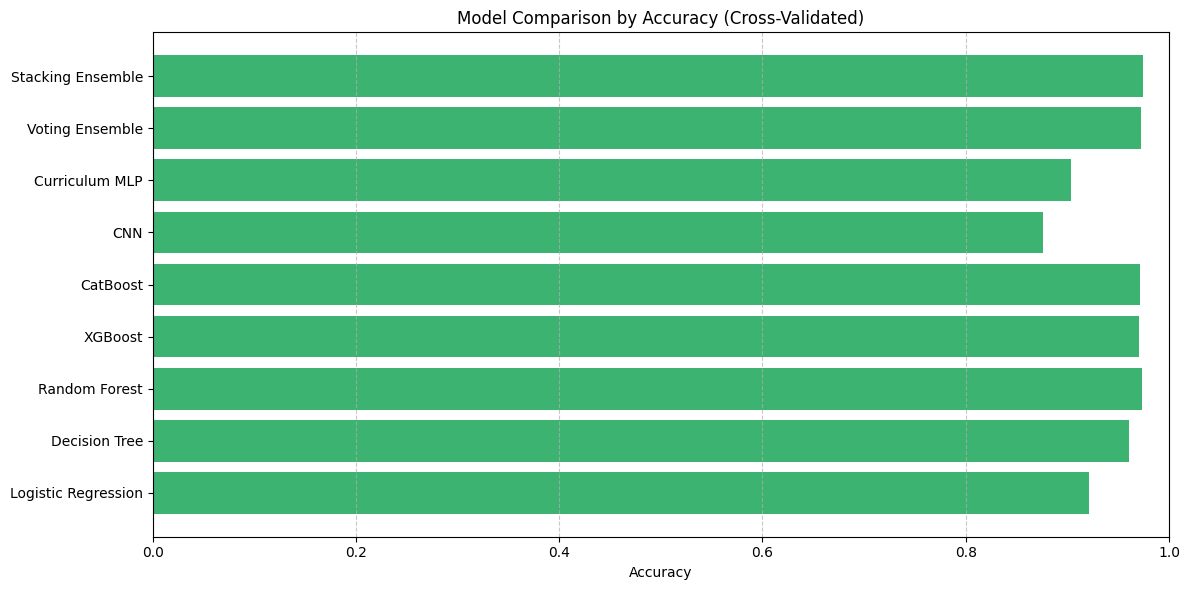

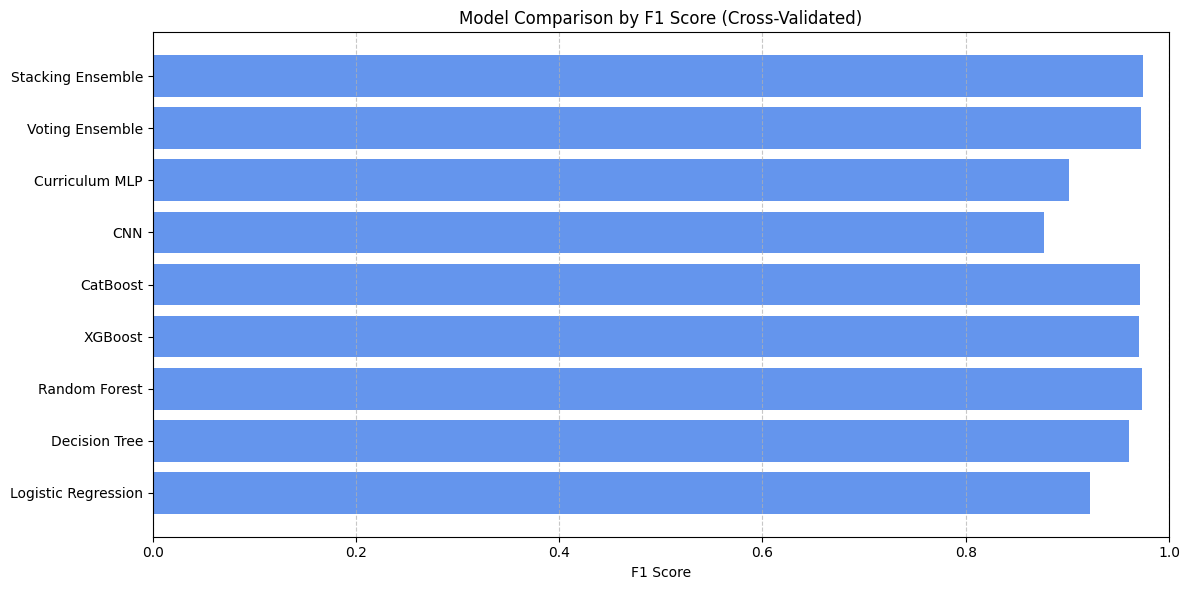

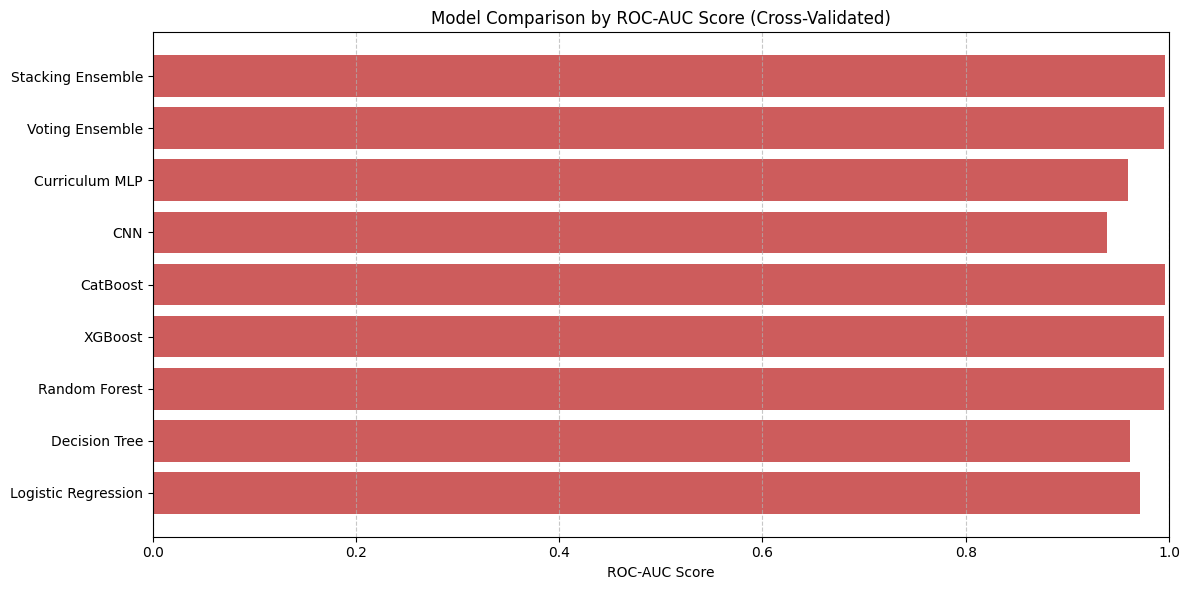

In [ ]:
# --- Reduced Feature Phishing Website Detection Model (Enhanced) ---

!pip install -q python-whois catboost imbalanced-learn

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout

from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

warnings.filterwarnings("ignore")

# Load dataset
file_path = '/content/drive/MyDrive/dataset_full.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Not found: {file_path}")
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()
print("Dataset shape:", df.shape)
print("Missing values:", df.isnull().sum().sum())

# Detect URL and label columns
def detect_column(possible_names):
    for name in possible_names:
        for col in df.columns:
            if col.strip().lower() == name.lower() or name.lower() in col.lower():
                return col
    return None

url_col = detect_column(['url', 'URL', 'website'])
label_col = detect_column(['phishing', 'label', 'target', 'status'])

if url_col is None or label_col is None:
    print("Available columns in DataFrame:", df.columns)
    raise ValueError(f"Detected column(s) missing. URL: {url_col}, Label: {label_col}")

# Identify URL-related features (heuristic based on common URL patterns)
excluded_cols = [label_col, url_col]
url_features = [col for col in df.columns if any(key in col.lower() for key in
                   ['url', 'domain', 'dns', 'ip', 'https', 'ssl', 'redirect',
                    'prefix', 'subdomain', 'length', 'dot', 'hostname', 'port'])
                and col not in excluded_cols]

if len(url_features) < 12:
    print(f"Warning: Only {len(url_features)} URL-related features found.")

# Prepare for feature selection
X_url = df[url_features].fillna(0).copy()
y_url = df[label_col]

# Encode labels if needed
if y_url.dtype == 'object':
    y_url = LabelEncoder().fit_transform(y_url)

# Balance with SMOTE
X_url_bal, y_url_bal = SMOTE(random_state=42).fit_resample(X_url, y_url)

# Use RandomForest to select top 12 features
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_url_bal, y_url_bal)
feature_importances = pd.Series(rf_temp.feature_importances_, index=X_url.columns)
top_12_features = feature_importances.nlargest(12).index.tolist()

print("\nTop 12 URL-based features selected:")
for i, feat in enumerate(top_12_features, 1):
    print(f"{i}. {feat}")

# Final dataset using top 12 features
X = df[top_12_features].fillna(0).values
y = df[label_col]
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

# Resample the reduced feature set with SMOTE
X, y = SMOTE(random_state=42).fit_resample(X, y)
input_dim = X.shape[1]

# Define neural network models
def create_cnn_model():
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_curriculum_model():
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define classical and neural models
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(verbose=0),
    'CNN': create_cnn_model,
    'Curriculum MLP': create_curriculum_model
}

# Ensemble definitions
estimators = [
    ('lr', LogisticRegression(max_iter=2000)),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]
voting_clf = VotingClassifier(estimators=estimators, voting='soft')
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=2000))

# Evaluate all models
accuracies, f1_scores, roc_aucs = {}, {}, {}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n--- {name} (Cross-Validation) ---")
    if name not in ['CNN', 'Curriculum MLP']:
        scores = cross_validate(model, X, y, cv=kfold, scoring=['accuracy', 'f1', 'roc_auc'], n_jobs=1)
        acc = np.mean(scores['test_accuracy'])
        f1 = np.mean(scores['test_f1'])
        roc = np.mean(scores['test_roc_auc'])
    else:
        acc_list, f1_list, roc_list = [], [], []
        for train_idx, test_idx in kfold.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            nn_model = model()
            nn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=0)
            y_pred_prob = nn_model.predict(X_test).flatten()
            y_pred = (y_pred_prob > 0.5).astype(int)
            acc_list.append(accuracy_score(y_test, y_pred))
            f1_list.append(f1_score(y_test, y_pred))
            roc_list.append(roc_auc_score(y_test, y_pred_prob))
        acc, f1, roc = np.mean(acc_list), np.mean(f1_list), np.mean(roc_list)
    print(f"Accuracy: {acc:.4f}\nF1 Score: {f1:.4f}\nROC-AUC: {roc:.4f}")
    accuracies[name], f1_scores[name], roc_aucs[name] = acc, f1, roc

# Evaluate ensembles
print("\n--- Voting Ensemble (Cross-Validation) ---")
voting_scores = cross_validate(voting_clf, X, y, cv=kfold, scoring=['accuracy', 'f1', 'roc_auc'], n_jobs=1)
accuracies['Voting Ensemble'] = np.mean(voting_scores['test_accuracy'])
f1_scores['Voting Ensemble'] = np.mean(voting_scores['test_f1'])
roc_aucs['Voting Ensemble'] = np.mean(voting_scores['test_roc_auc'])
print("Accuracy:", accuracies['Voting Ensemble'])
print("F1 Score:", f1_scores['Voting Ensemble'])
print("ROC-AUC:", roc_aucs['Voting Ensemble'])

print("\n--- Stacking Ensemble (Cross-Validation) ---")
stacking_scores = cross_validate(stacking_clf, X, y, cv=kfold, scoring=['accuracy', 'f1', 'roc_auc'], n_jobs=1)
accuracies['Stacking Ensemble'] = np.mean(stacking_scores['test_accuracy'])
f1_scores['Stacking Ensemble'] = np.mean(stacking_scores['test_f1'])
roc_aucs['Stacking Ensemble'] = np.mean(stacking_scores['test_roc_auc'])
print("Accuracy:", accuracies['Stacking Ensemble'])
print("F1 Score:", f1_scores['Stacking Ensemble'])
print("ROC-AUC:", roc_aucs['Stacking Ensemble'])

# Visualization
for metric_dict, title, color in zip([accuracies, f1_scores, roc_aucs],
                                     ["Accuracy", "F1 Score", "ROC-AUC Score"],
                                     ['mediumseagreen', 'cornflowerblue', 'indianred']):
    plt.figure(figsize=(12, 6))
    plt.title(f'Model Comparison by {title} (Cross-Validated)')
    plt.barh(list(metric_dict.keys()), list(metric_dict.values()), color=color)
    plt.xlabel(title)
    plt.xlim(0, 1)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# --- End of Script ---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# --- Reduced Feature Phishing Website Detection Model (10 Features) ---

!pip install -q python-whois catboost

import pandas as pd
import numpy as np
import re
import ipaddress
from urllib.parse import urlparse
import requests
import socket
import ssl
import math
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout

from google.colab import drive
import os

%load_ext cudf.pandas

# Mount Google Drive
drive.mount('/content/drive')

warnings.filterwarnings("ignore")
USE_WHOIS = False

# Feature extraction helpers
def get_domain(url):
    try:
        domain = urlparse(url).netloc
        if domain.startswith("www."):
            domain = domain[4:]
        return domain
    except:
        return ""

def https_present(url):
    return 1 if url.startswith("https") else 0

def get_ssl_issuer(domain):
    try:
        ctx = ssl.create_default_context()
        with ctx.wrap_socket(socket.socket(), server_hostname=domain) as s:
            s.settimeout(2)
            s.connect((domain, 443))
            cert = s.getpeercert()
            issuer = cert.get('issuer', '')
            return 0 if "Let's Encrypt" in str(issuer) or "Self" in str(issuer) else 1
    except:
        return 0

def character_entropy(url):
    prob = [float(url.count(c)) / len(url) for c in dict.fromkeys(list(url))]
    return -sum([p * math.log(p) / math.log(2.0) for p in prob])

def featureExtraction(url):
    features = []
    domain = get_domain(url)
    features.append(1 if re.match(r"^(?:[0-9]{1,3}\.){3}[0-9]{1,3}$", domain) else 0)  # IP-based URL
    features.append(1 if "@" in url else 0)  # @ Symbol
    features.append(1 if len(url) >= 54 else 0)  # URL Length
    features.append(1 if '-' in domain else 0)  # Hyphen in domain
    features.append(https_present(url))  # HTTPS
    features.append(get_ssl_issuer(domain))  # SSL issuer
    features.append(character_entropy(url))  # Entropy
    features.append(url.count('.'))  # Number of dots
    features.append(sum(c.isdigit() for c in url))  # Digit count
    features.append(sum(c.isalpha() for c in url))  # Alphabet count
    return features

# Load dataset
file_path = '/content/drive/MyDrive/dataset_phishingKAGGLE.csv'
df = pd.read_csv(file_path) if os.path.exists(file_path) else FileNotFoundError(f"Not found: {file_path}")
print("Dataset shape:", df.shape)
print("Missing values:", df.isnull().sum().sum())

urls = df['url']
X = np.array([featureExtraction(url) for url in urls])

target_column = 'status' if 'status' in df.columns else df.columns[-1]
y = df[target_column]
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

input_dim = X.shape[1]
def create_cnn_model():
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_curriculum_model():
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(verbose=0),
    'CNN': create_cnn_model,
    'Curriculum MLP': create_curriculum_model
}

estimators = [
    ('lr', LogisticRegression(max_iter=2000)),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('svm', SVC(probability=True))
]
voting_clf = VotingClassifier(estimators=estimators, voting='soft')
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=2000))

accuracies, f1_scores, roc_aucs = {}, {}, {}
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

for name, model in models.items():
    print(f"\n--- {name} (Cross-Validation) ---")
    if name not in ['CNN', 'Curriculum MLP']:
        scores = cross_validate(model, X, y, cv=kfold, scoring=['accuracy', 'f1', 'roc_auc'], n_jobs=-1)
        acc = np.mean(scores['test_accuracy'])
        f1 = np.mean(scores['test_f1'])
        roc = np.mean(scores['test_roc_auc'])
    else:
        acc_list, f1_list, roc_list = [], [], []
        for train_idx, test_idx in kfold.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            nn_model = model()
            nn_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
            y_pred_prob = nn_model.predict(X_test).flatten()
            y_pred = (y_pred_prob > 0.5).astype(int)
            acc_list.append(accuracy_score(y_test, y_pred))
            f1_list.append(f1_score(y_test, y_pred))
            roc_list.append(roc_auc_score(y_test, y_pred_prob))
        acc = np.mean(acc_list)
        f1 = np.mean(f1_list)
        roc = np.mean(roc_list)
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc:.4f}")
    accuracies[name], f1_scores[name], roc_aucs[name] = acc, f1, roc

print("\n--- Voting Ensemble (Cross-Validation) ---")
voting_scores = cross_validate(voting_clf, X, y, cv=kfold, scoring=['accuracy', 'f1', 'roc_auc'], n_jobs=-1)
accuracies['Voting Ensemble'] = np.mean(voting_scores['test_accuracy'])
f1_scores['Voting Ensemble'] = np.mean(voting_scores['test_f1'])
roc_aucs['Voting Ensemble'] = np.mean(voting_scores['test_roc_auc'])

print("Accuracy:", accuracies['Voting Ensemble'])
print("F1 Score:", f1_scores['Voting Ensemble'])
print("ROC-AUC:", roc_aucs['Voting Ensemble'])

print("\n--- Stacking Ensemble (Cross-Validation) ---")
stacking_scores = cross_validate(stacking_clf, X, y, cv=kfold, scoring=['accuracy', 'f1', 'roc_auc'], n_jobs=-1)
accuracies['Stacking Ensemble'] = np.mean(stacking_scores['test_accuracy'])
f1_scores['Stacking Ensemble'] = np.mean(stacking_scores['test_f1'])
roc_aucs['Stacking Ensemble'] = np.mean(stacking_scores['test_roc_auc'])

print("Accuracy:", accuracies['Stacking Ensemble'])
print("F1 Score:", f1_scores['Stacking Ensemble'])
print("ROC-AUC:", roc_aucs['Stacking Ensemble'])

# Plots
plt.figure(figsize=(12, 6))
plt.title('Model Comparison by Accuracy (Cross-Validated)')
plt.barh(list(accuracies.keys()), list(accuracies.values()), color='mediumseagreen')
plt.xlabel('Accuracy')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.title('Model Comparison by F1 Score (Cross-Validated)')
plt.barh(list(f1_scores.keys()), list(f1_scores.values()), color='cornflowerblue')
plt.xlabel('F1 Score')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.title('Model Comparison by ROC-AUC Score (Cross-Validated)')
plt.barh(list(roc_aucs.keys()), list(roc_aucs.values()), color='indianred')
plt.xlabel('ROC-AUC Score')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- End of Script ---


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━ 46.2/99.2 MB 42.5 MB/s eta 0:00:02
ERROR: Operation cancelled by user


ModuleNotFoundError: No module named 'catboost'

In [ ]:
# --- GPU-Enhanced Phishing Detection Script (10 Features) ---

!pip install -q python-whois catboost xgboost imbalanced-learn

import pandas as pd
import numpy as np
import re
import ipaddress
from urllib.parse import urlparse
import requests
import socket
import ssl
import math
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout

from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

warnings.filterwarnings("ignore")
USE_WHOIS = False

# Check TensorFlow GPU availability
print("TensorFlow GPU Available:", tf.config.list_physical_devices('GPU'))

# Feature extraction helpers
def get_domain(url):
    try:
        domain = urlparse(str(url)).netloc
        if domain.startswith("www."):
            domain = domain[4:]
        return domain
    except:
        return ""

def https_present(url):
    return 1 if str(url).startswith("https") else 0

def get_ssl_issuer(domain):
    try:
        ctx = ssl.create_default_context()
        with ctx.wrap_socket(socket.socket(), server_hostname=domain) as s:
            s.settimeout(2)
            s.connect((domain, 443))
            cert = s.getpeercert()
            issuer = cert.get('issuer', '')
            return 0 if "Let's Encrypt" in str(issuer) or "Self" in str(issuer) else 1
    except:
        return 0

def character_entropy(url):
    try:
        url = str(url)
        prob = [float(url.count(c)) / len(url) for c in dict.fromkeys(list(url))]
        return -sum([p * math.log(p) / math.log(2.0) for p in prob])
    except:
        return 0

def featureExtraction(url):
    url = str(url)
    features = []
    domain = get_domain(url)
    features.append(1 if re.match(r"^(?:[0-9]{1,3}\.){3}[0-9]{1,3}$", domain) else 0)  # IP-based URL
    features.append(1 if "@" in url else 0)  # @ Symbol
    features.append(1 if len(url) >= 54 else 0)  # URL Length
    features.append(1 if '-' in domain else 0)  # Hyphen in domain
    features.append(https_present(url))  # HTTPS
    features.append(get_ssl_issuer(domain))  # SSL issuer
    features.append(character_entropy(url))  # Entropy
    features.append(url.count('.'))  # Number of dots
    features.append(sum(c.isdigit() for c in url))  # Digit count
    features.append(sum(c.isalpha() for c in url))  # Alphabet count
    return features

# Load dataset
file_path = '/content/drive/MyDrive/dataset_full.csv'
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    raise FileNotFoundError(f"Not found: {file_path}")

df.columns = df.columns.str.strip().str.lower()  # Normalize column names
print("Dataset shape:", df.shape)
print("Missing values:", df.isnull().sum().sum())

if df.shape[1] < 2:
    raise IndexError("Dataset does not have at least two columns. Columns found: " + str(df.columns.tolist()))

urls = df.iloc[:, 1].astype(str)
X = np.array([featureExtraction(url) for url in urls])

target_column = 'status' if 'status' in df.columns else df.columns[-1]
y = df[target_column]
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)
y = np.array(y)

input_dim = X.shape[1]
def create_cnn_model():
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_curriculum_model():
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist', predictor='gpu_predictor'),
    'CatBoost': CatBoostClassifier(verbose=0, task_type="GPU"),
    'CNN': create_cnn_model,
    'Curriculum MLP': create_curriculum_model
}

estimators = [
    ('lr', LogisticRegression(max_iter=2000)),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist', predictor='gpu_predictor')),
    ('svm', SVC(probability=True))
]
voting_clf = VotingClassifier(estimators=estimators, voting='soft')
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=2000))

accuracies, f1_scores, roc_aucs = {}, {}, {}
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

for name, model in models.items():
    print(f"\n--- {name} (Cross-Validation) ---")
    if name not in ['CNN', 'Curriculum MLP']:
        scores = cross_validate(model, X, y, cv=kfold, scoring=['accuracy', 'f1', 'roc_auc'], n_jobs=-1)
        acc = np.mean(scores['test_accuracy'])
        f1 = np.mean(scores['test_f1'])
        roc = np.mean(scores['test_roc_auc'])
    else:
        acc_list, f1_list, roc_list = [], [], []
        for train_idx, test_idx in kfold.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            nn_model = model()
            nn_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
            y_pred_prob = nn_model.predict(X_test).flatten()
            y_pred = (y_pred_prob > 0.5).astype(int)
            acc_list.append(accuracy_score(y_test, y_pred))
            f1_list.append(f1_score(y_test, y_pred))
            roc_list.append(roc_auc_score(y_test, y_pred_prob))
        acc = np.mean(acc_list)
        f1 = np.mean(f1_list)
        roc = np.mean(roc_list)
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc:.4f}")
    accuracies[name], f1_scores[name], roc_aucs[name] = acc, f1, roc

print("\n--- Voting Ensemble (Cross-Validation) ---")
voting_scores = cross_validate(voting_clf, X, y, cv=kfold, scoring=['accuracy', 'f1', 'roc_auc'], n_jobs=-1)
accuracies['Voting Ensemble'] = np.mean(voting_scores['test_accuracy'])
f1_scores['Voting Ensemble'] = np.mean(voting_scores['test_f1'])
roc_aucs['Voting Ensemble'] = np.mean(voting_scores['test_roc_auc'])

print("Accuracy:", accuracies['Voting Ensemble'])
print("F1 Score:", f1_scores['Voting Ensemble'])
print("ROC-AUC:", roc_aucs['Voting Ensemble'])

print("\n--- Stacking Ensemble (Cross-Validation) ---")
stacking_scores = cross_validate(stacking_clf, X, y, cv=kfold, scoring=['accuracy', 'f1', 'roc_auc'], n_jobs=-1)
accuracies['Stacking Ensemble'] = np.mean(stacking_scores['test_accuracy'])
f1_scores['Stacking Ensemble'] = np.mean(stacking_scores['test_f1'])
roc_aucs['Stacking Ensemble'] = np.mean(stacking_scores['test_roc_auc'])

print("Accuracy:", accuracies['Stacking Ensemble'])
print("F1 Score:", f1_scores['Stacking Ensemble'])
print("ROC-AUC:", roc_aucs['Stacking Ensemble'])

# Plots
plt.figure(figsize=(12, 6))
plt.title('Model Comparison by Accuracy (Cross-Validated)')
plt.barh(list(accuracies.keys()), list(accuracies.values()), color='mediumseagreen')
plt.xlabel('Accuracy')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.title('Model Comparison by F1 Score (Cross-Validated)')
plt.barh(list(f1_scores.keys()), list(f1_scores.values()), color='cornflowerblue')
plt.xlabel('F1 Score')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.title('Model Comparison by ROC-AUC Score (Cross-Validated)')
plt.barh(list(roc_aucs.keys()), list(roc_aucs.values()), color='indianred')
plt.xlabel('ROC-AUC Score')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
